In [1]:
import numpy as np 
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNetCV, ElasticNet
from xgboost import XGBRegressor, plot_importance 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

In [2]:
data = pd.read_csv("/home/shri/Downloads/Housing/data/house_train.csv")
data.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [4]:
(data.isnull().sum() / len(data)).sort_values(ascending=False)[:20]

PoolQC         0.995
MiscFeature    0.963
Alley          0.938
Fence          0.808
FireplaceQu    0.473
LotFrontage    0.177
GarageCond     0.055
GarageType     0.055
GarageYrBlt    0.055
GarageFinish   0.055
GarageQual     0.055
BsmtExposure   0.026
BsmtFinType2   0.026
BsmtFinType1   0.025
BsmtCond       0.025
BsmtQual       0.025
MasVnrArea     0.005
MasVnrType     0.005
Electrical     0.001
Utilities      0.000
dtype: float64

In [6]:
df.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'Id'], axis=1, inplace=True)

In [7]:
df['SalePrice'].describe()

count     1460.000
mean    180921.196
std      79442.503
min      34900.000
25%     129975.000
50%     163000.000
75%     214000.000
max     755000.000
Name: SalePrice, dtype: float64


 mu = 180921.20 and sigma = 79415.29



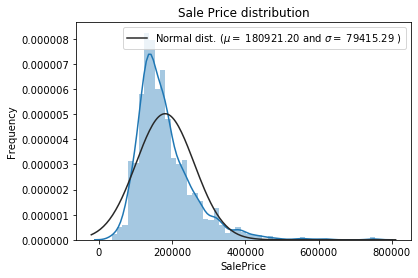

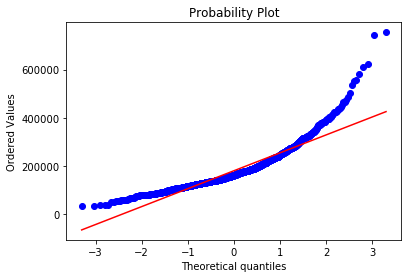

In [5]:
sns.distplot(data['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(data['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Sale Price distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(data['SalePrice'], plot=plt)
plt.show();


 mu = 12.02 and sigma = 0.40



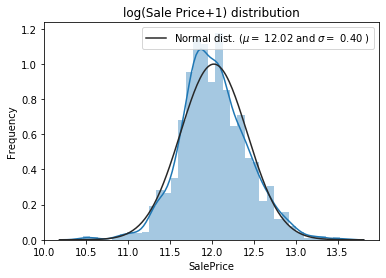

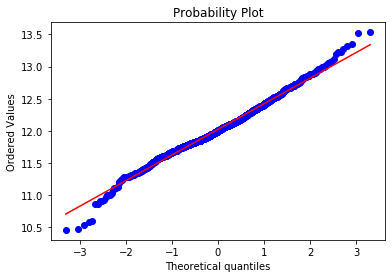

In [9]:
sns.distplot(np.log1p(df['SalePrice']) , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(np.log1p(df['SalePrice']))
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('log(Sale Price+1) distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(np.log1p(df['SalePrice']), plot=plt)
plt.show();

### Correlation between numeric features

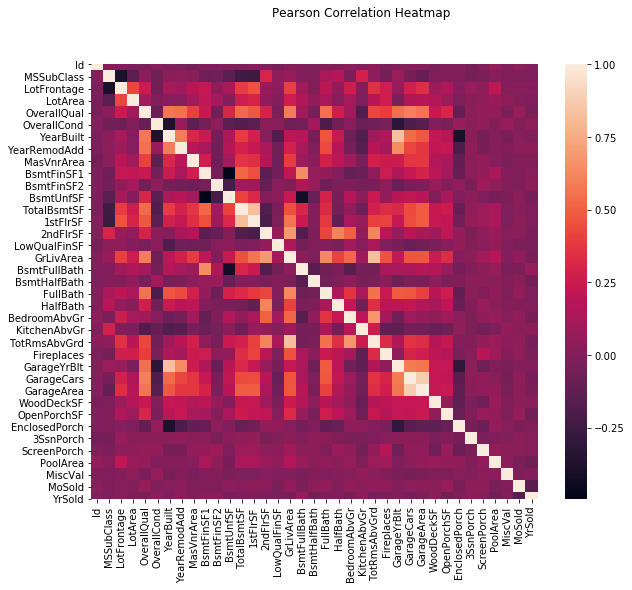

In [6]:
pd.set_option('precision',2)
plt.figure(figsize=(10, 8))
sns.heatmap(data.drop(['SalePrice'],axis=1).corr(), square=True)
plt.suptitle("Pearson Correlation Heatmap")
plt.show();

There exists strong correlations between some of the features. For example, GarageYrBlt and YearBuilt, TotRmsAbvGrd and GrLivArea, GarageArea and GarageCars are strongly correlated. They actually express more or less the same thing. I will let ElasticNetCV to help reduce redundancy.

### Correlation between SalePrice  and the other numeric features

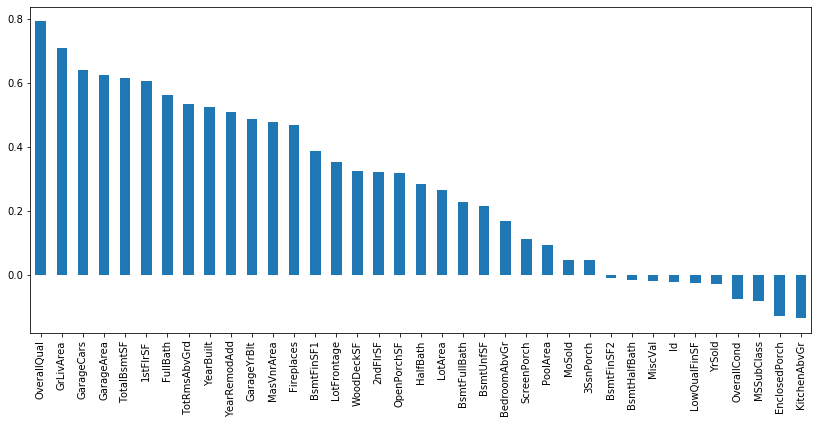

In [7]:
corr_with_sale_price = data.corr()["SalePrice"].sort_values(ascending=False)
plt.figure(figsize=(14,6))
corr_with_sale_price.drop("SalePrice").plot.bar()
plt.show();

The correlation of Sale Price with OverallQual is the greatest (around 0.8). Also GrLivArea presents a correlation of over 0.7, and GarageCars presents a correlation of over 0.6.

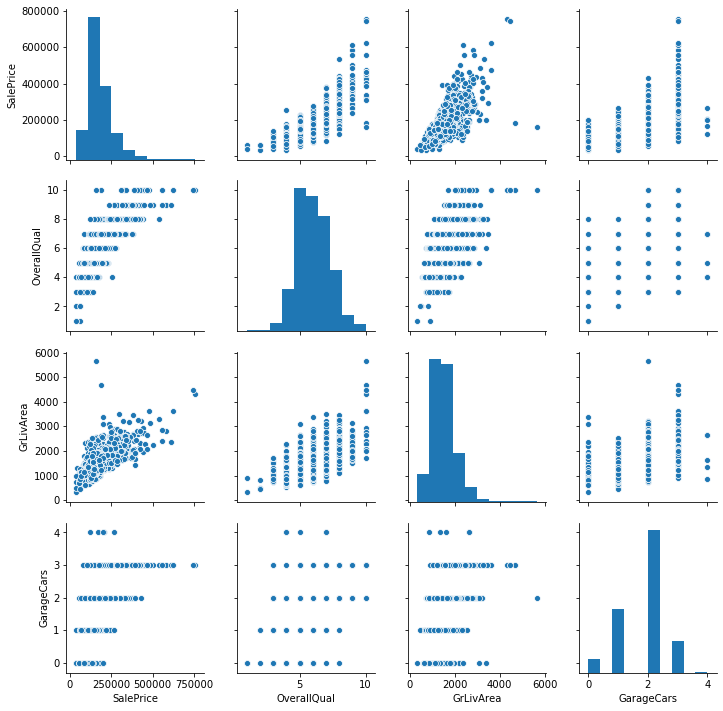

In [8]:
sns.pairplot(data[['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars']])
plt.show();

Log transform the target feature and all the other skewed numerical features. 

In [10]:
data["SalePrice"] = np.log1p(data["SalePrice"])

#log transform skewed numeric features:
numeric_feats = data.dtypes[data.dtypes != "object"].index

skewed_feats = data[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

data[skewed_feats] = np.log1p(data[skewed_feats])

/home/shri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log1p
  # Remove the CWD from sys.path while we load stuff.


In [12]:
data = pd.get_dummies(data)
data = data.fillna(data.mean())

In [14]:
X, y = data.drop(['SalePrice'], axis = 1), data['SalePrice']

X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size = 0.2, random_state = 0)

### ElasticNetCV

In [15]:
cv_model = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], eps=1e-3, n_alphas=100, fit_intercept=True, 
                        normalize=True, precompute='auto', max_iter=2000, tol=0.0001, cv=6, 
                        copy_X=True, verbose=0, n_jobs=-1, positive=False, random_state=0)

In [16]:
cv_model.fit(X_train, y_train)

ElasticNetCV(alphas=None, copy_X=True, cv=6, eps=0.001, fit_intercept=True,
             l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], max_iter=2000,
             n_alphas=100, n_jobs=-1, normalize=True, positive=False,
             precompute='auto', random_state=0, selection='cyclic', tol=0.0001,
             verbose=0)

In [17]:
print('Optimal alpha: %.8f'%cv_model.alpha_)
print('Optimal l1_ratio: %.3f'%cv_model.l1_ratio_)
print('Number of iterations %d'%cv_model.n_iter_)

Optimal alpha: 0.00001568
Optimal l1_ratio: 0.500
Number of iterations 131


In [18]:
y_train_pred = cv_model.predict(X_train)
y_pred = cv_model.predict(X_test)
print('Train r2 score: ', r2_score(y_train_pred, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred))
train_mse = mean_squared_error(y_train_pred, y_train)
test_mse = mean_squared_error(y_pred, y_test)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
print('Train RMSE: %.4f' % train_rmse)
print('Test RMSE: %.4f' % test_rmse)

Train r2 score:  0.9358113955763451
Test r2 score:  0.8197133349966222
Train RMSE: 0.0074
Test RMSE: 0.0126


109 features, reduction of 62.28%


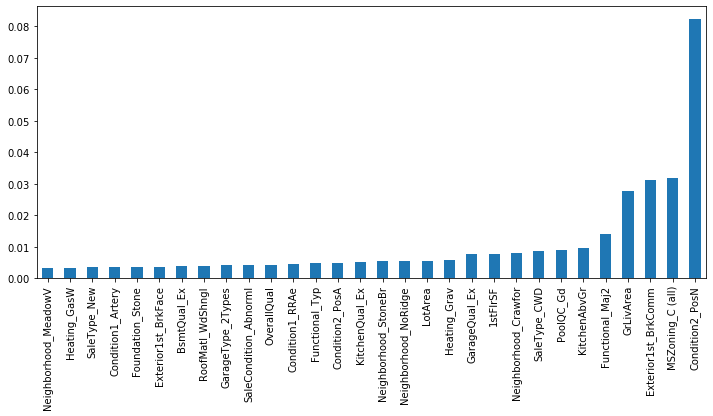

In [19]:
feature_importance = pd.Series(index = X_train.columns, data = np.abs(cv_model.coef_))

n_selected_features = (feature_importance>0).sum()
print('{0:d} features, reduction of {1:2.2f}%'.format(
    n_selected_features,(1-n_selected_features/len(feature_importance))*100))

feature_importance.sort_values().tail(30).plot(kind = 'bar', figsize = (12,5));

### Xgboost

In [20]:
from xgboost import XGBRegressor, plot_importance 
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

In [21]:
xgb_model1 = XGBRegressor()
xgb_model1.fit(X_train, y_train, verbose=False)

[23:20:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [22]:
y_train_pred1 = xgb_model1.predict(X_train)
y_pred1 = xgb_model1.predict(X_test)

print('Train r2 score: ', r2_score(y_train_pred1, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred1))
train_mse1 = mean_squared_error(y_train_pred1, y_train)
test_mse1 = mean_squared_error(y_pred1, y_test)
train_rmse1 = np.sqrt(train_mse1)
test_rmse1 = np.sqrt(test_mse1)
print('Train RMSE: %.4f' % train_rmse1)
print('Test RMSE: %.4f' % test_rmse1)

Train r2 score:  0.9525779564962048
Test r2 score:  0.885405922010795
Train RMSE: 0.0064
Test RMSE: 0.0100


In [23]:
xgb_model2 = XGBRegressor(n_estimators=1000)
xgb_model2.fit(X_train, y_train, early_stopping_rounds=5, 
             eval_set=[(X_test, y_test)], verbose=False)
y_train_pred2 = xgb_model2.predict(X_train)
y_pred2 = xgb_model2.predict(X_test)

print('Train r2 score: ', r2_score(y_train_pred2, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred2))
train_mse2 = mean_squared_error(y_train_pred2, y_train)
test_mse2 = mean_squared_error(y_pred2, y_test)
train_rmse2 = np.sqrt(train_mse2)
test_rmse2 = np.sqrt(test_mse2)
print('Train RMSE: %.4f' % train_rmse2)
print('Test RMSE: %.4f' % test_rmse2)

[23:21:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train r2 score:  0.9635662941569624
Test r2 score:  0.8901501458945474
Train RMSE: 0.0057
Test RMSE: 0.0098


It was an improvement!

In [24]:
xgb_model3 = XGBRegressor(n_estimators=1000, learning_rate=0.05)
xgb_model3.fit(X_train, y_train, early_stopping_rounds=5, 
             eval_set=[(X_test, y_test)], verbose=False)
y_train_pred3 = xgb_model3.predict(X_train)
y_pred3 = xgb_model3.predict(X_test)

print('Train r2 score: ', r2_score(y_train_pred3, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred3))
train_mse3 = mean_squared_error(y_train_pred3, y_train)
test_mse3 = mean_squared_error(y_pred3, y_test)
train_rmse3 = np.sqrt(train_mse3)
test_rmse3 = np.sqrt(test_mse3)
print('Train RMSE: %.4f' % train_rmse3)
print('Test RMSE: %.4f' % test_rmse3)

[23:21:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train r2 score:  0.9600169644737734
Test r2 score:  0.8892855464433633
Train RMSE: 0.0059
Test RMSE: 0.0099


There was no improvement.

In [25]:
xgb_model4 = XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                         colsample_bytree=1, max_depth=7, n_jobs=-1)
xgb_model4.fit(X_train,y_train)
y_train_pred4 = xgb_model4.predict(X_train)
y_pred4 = xgb_model4.predict(X_test)

print('Train r2 score: ', r2_score(y_train_pred4, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred4))
train_mse4 = mean_squared_error(y_train_pred4, y_train)
test_mse4 = mean_squared_error(y_pred4, y_test)
train_rmse4 = np.sqrt(train_mse4)
test_rmse4 = np.sqrt(test_mse4)
print('Train RMSE: %.4f' % train_rmse4)
print('Test RMSE: %.4f' % test_rmse4)

[23:21:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train r2 score:  0.9834654608789687
Test r2 score:  0.8797310796887725
Train RMSE: 0.0039
Test RMSE: 0.0103


I concluded that xgb_model2 is the best model.

In [26]:
from collections import OrderedDict
OrderedDict(sorted(xgb_model2.get_booster().get_fscore().items(), key=lambda t: t[1], reverse=True))

OrderedDict([('GrLivArea', 57),
             ('Id', 50),
             ('LotArea', 46),
             ('OverallQual', 43),
             ('OverallCond', 34),
             ('TotalBsmtSF', 33),
             ('GarageArea', 23),
             ('YearBuilt', 22),
             ('BsmtFinSF1', 22),
             ('OpenPorchSF', 19),
             ('GarageYrBlt', 19),
             ('LotFrontage', 18),
             ('YearRemodAdd', 15),
             ('BsmtUnfSF', 15),
             ('MoSold', 14),
             ('Functional_Typ', 13),
             ('EnclosedPorch', 13),
             ('1stFlrSF', 12),
             ('MSZoning_C (all)', 12),
             ('SaleCondition_Abnorml', 11),
             ('MasVnrArea', 11),
             ('2ndFlrSF', 11),
             ('WoodDeckSF', 10),
             ('Neighborhood_Crawfor', 10),
             ('ScreenPorch', 8),
             ('Fence_GdWo', 7),
             ('Condition1_Norm', 7),
             ('Exterior1st_BrkFace', 7),
             ('Fireplaces', 6),
             

In [27]:
most_relevant_features= list( dict((k, v) for k, v in xgb_model2.get_booster().get_fscore().items() if v >= 4).keys())
print(most_relevant_features)

['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', '1stFlrSF', 'OpenPorchSF', 'GarageType_Attchd', 'MSZoning_C (all)', 'YearBuilt', 'Fireplaces', 'YearRemodAdd', 'OverallCond', 'MSZoning_RL', 'GarageArea', 'Fence_GdWo', 'LotFrontage', 'KitchenAbvGr', 'LotArea', 'BsmtFinSF1', 'GarageYrBlt', 'Neighborhood_OldTown', 'SaleCondition_Abnorml', 'BedroomAbvGr', 'KitchenQual_Ex', 'WoodDeckSF', 'Functional_Typ', 'Neighborhood_Mitchel', 'Id', 'BsmtExposure_Gd', 'Neighborhood_Crawfor', 'BsmtUnfSF', 'SaleCondition_Family', 'Condition1_Artery', 'EnclosedPorch', 'MSSubClass', 'MoSold', 'SaleType_New', 'MasVnrArea', 'YrSold', '2ndFlrSF', 'BsmtFullBath', 'Exterior2nd_Wd Shng', 'FullBath', 'Neighborhood_ClearCr', 'ScreenPorch', 'Condition1_Norm', 'Exterior1st_BrkFace', 'BsmtQual_Gd', 'Neighborhood_BrkSide', 'BsmtFinSF2', 'PoolArea', 'MSZoning_FV', 'Alley_Pave']


In [30]:
train_x=data[most_relevant_features]
train_y=data['SalePrice']
X_train, X_test, y_train, y_test  = train_test_split(train_x, train_y, test_size = 0.2, random_state = 0)

In [31]:
xgb_model5 = XGBRegressor(n_estimators=1000)
xgb_model5.fit(X_train, y_train, early_stopping_rounds=5, 
             eval_set=[(X_test, y_test)], verbose=False)
y_train_pred5 = xgb_model5.predict(X_train)
y_pred5 = xgb_model5.predict(X_test)

print('Train r2 score: ', r2_score(y_train_pred5, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred5))
train_mse5 = mean_squared_error(y_train_pred5, y_train)
test_mse5 = mean_squared_error(y_pred5, y_test)
train_rmse5 = np.sqrt(train_mse5)
test_rmse5 = np.sqrt(test_mse5)
print('Train RMSE: %.4f' % train_rmse5)
print('Test RMSE: %.4f' % test_rmse5)

[23:21:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train r2 score:  0.9511256312235016
Test r2 score:  0.8890051040313871
Train RMSE: 0.0065
Test RMSE: 0.0099


Another improvement.